--- Step 1: Checking Hardware ---
GPU Available: True
------------------------------
--- Step 2: Loading and Preparing Data for Training ---
Loading data from: d:\Projects\aki_prediction_project\data\processed\train_data.csv
Successfully loaded 2746640 records.
------------------------------
--- Step 3: Validating a Saved Spectrogram and Creating a Stratified Sample ---
Using a stratified sample of 200 records for this test.
Class distribution in sample:
aki_label
0    150
1     50
Name: count, dtype: int64

Loading file for validation: d:\Projects\aki_prediction_project\data\processed\spectrograms/pleth\5703_414.npy
Validation successful!
  - Loaded array shape: (129, 6)
  - Loaded array data type: float32


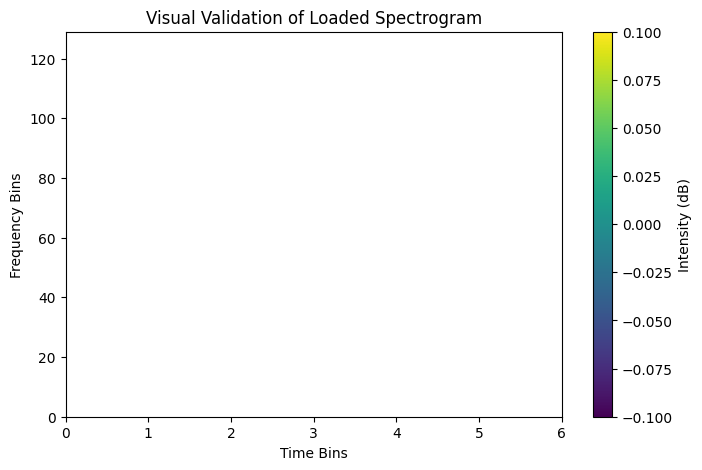

------------------------------
--- Step 4: Initializing and Training Model ---
Model: efficientnet_b0
Time Limit: 300 seconds
Starting VRAM monitor...
[VRAM Monitor] Usage: 2386936.00 / 6291456.00 GiB


=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.9.23
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          12
Pytorch Version:    2.5.1
CUDA Version:       11.8
Memory Avail:       5.58 GB / 31.35 GB (17.8%)
Disk Space Avail:   355.75 GB / 1863.00 GB (19.1%)

AutoMM starts to create your model. ✨✨✨

To track the learning progress, you can open a terminal and launch Tensorboard:
    ```shell
    # Assume you have installed tensorboard
    tensorboard --logdir d:\Projects\aki_prediction_project\models\autogluon_test_model
    ```

Seed set to 0


Stopping VRAM monitor...


ValueError: No model is available for this dataset.

In [7]:
import os
import pandas as pd
import numpy as np
from autogluon.multimodal import MultiModalPredictor
import torch # To check for GPU availability and for loss function
import matplotlib.pyplot as plt # For validation plotting
import threading
import time
try:
    import nvitop
except ImportError:
    print("nvitop not found. Please run 'pip install nvitop' in your environment.")
    nvitop = None

# --- GPU Monitoring Function ---
def monitor_gpu(stop_event):
    """Monitors and prints GPU VRAM usage in a separate thread."""
    if not nvitop or not torch.cuda.is_available():
        return
    
    device = nvitop.Device.all()[0] # Get the first GPU
    while not stop_event.is_set():
        # Get memory info
        memory_used = device.memory_used() / 1024  # in GiB
        memory_total = device.memory_total() / 1024 # in GiB
        print(f"[VRAM Monitor] Usage: {memory_used:.2f} / {memory_total:.2f} GiB")
        time.sleep(10) # Print every 10 seconds

# --- Configuration ---
# This block holds all the settings for our quick test run.

# 1. Data and Model Paths
# Note the '../' to correctly navigate from the 'notebooks/' directory up to the root.
TRAIN_DATA_PATH = '../data/processed/train_data.csv'
MODEL_SAVE_PATH = '../models/autogluon_test_model' # Path to save the temporary test model

# 2. Test Parameters
# We'll use a small subset of the data for a fast test.
SAMPLE_SIZE = 200 
# A short time limit to ensure the test finishes in a few minutes.
TIME_LIMIT_SECONDS = 300 

# 3. Model Hyperparameters
# FIX: Swapping to a known, stable, and powerful model to isolate the error.
# EfficientNet-B0 is a well-supported and excellent choice.
MODEL_CHECKPOINT = 'efficientnet_b0'


# --- Test Execution ---

# 1. Verify GPU Availability
print("--- Step 1: Checking Hardware ---")
is_gpu_available = torch.cuda.is_available()
print(f"GPU Available: {is_gpu_available}")
if not is_gpu_available:
    print("Warning: No GPU detected. Training will be very slow.")
print("-" * 30)


# 2. Load and Prepare Data
print(f"--- Step 2: Loading and Preparing Data for Training ---")
train_df = None # Initialize dataframe to None for graceful failure
try:
    print(f"Loading data from: {os.path.abspath(TRAIN_DATA_PATH)}")
    train_df = pd.read_csv(TRAIN_DATA_PATH)
    
    # Correctly construct the absolute path to the spectrogram files.
    # The paths in the CSV are relative to the 'processed' directory.
    processed_data_dir = os.path.dirname(os.path.abspath(TRAIN_DATA_PATH))
    train_df['image'] = train_df['image'].apply(lambda p: os.path.join(processed_data_dir, p))

    print(f"Successfully loaded {len(train_df)} records.")

except FileNotFoundError:
    print(f"ERROR: Could not find the training data file at {TRAIN_DATA_PATH}")
    print("Please ensure Phase 5 (data generation) has completed successfully. Halting test.")
    
print("-" * 30)


# The rest of the script will only run if the dataframe was loaded successfully
if train_df is not None:

    # 3. Validate a Saved .npy File and Create a Stratified Sample
    print("--- Step 3: Validating a Saved Spectrogram and Creating a Stratified Sample ---")
    validation_passed = False
    try:
        # Create a stratified sample to ensure both classes are present.
        # This prevents the "only one label class" error.
        pos_samples = train_df[train_df['aki_label'] == 1].sample(n=min(50, len(train_df[train_df['aki_label'] == 1])), random_state=42)
        neg_samples = train_df[train_df['aki_label'] == 0].sample(n=SAMPLE_SIZE - len(pos_samples), random_state=42)
        test_sample_df = pd.concat([pos_samples, neg_samples]).sample(frac=1, random_state=42).reset_index(drop=True)

        print(f"Using a stratified sample of {len(test_sample_df)} records for this test.")
        print("Class distribution in sample:")
        print(test_sample_df['aki_label'].value_counts())

        first_image_path = test_sample_df['image'].iloc[0]
        print(f"\nLoading file for validation: {first_image_path}")
        
        # Load the numpy array from the file
        loaded_spectrogram = np.load(first_image_path)
        
        print(f"Validation successful!")
        print(f"  - Loaded array shape: {loaded_spectrogram.shape}")
        print(f"  - Loaded array data type: {loaded_spectrogram.dtype}")
        
        # Plot the loaded spectrogram to visually confirm it's correct
        plt.figure(figsize=(8, 5))
        # FIX: Reverting to plt.pcolormesh and dynamically setting color range
        vmin = np.percentile(loaded_spectrogram, 5)  # Lower bound for color scaling
        vmax = np.percentile(loaded_spectrogram, 95) # Upper bound for color scaling
        plt.pcolormesh(loaded_spectrogram, cmap='viridis', vmin=vmin, vmax=vmax)
        plt.title("Visual Validation of Loaded Spectrogram")
        plt.ylabel("Frequency Bins")
        plt.xlabel("Time Bins")
        plt.colorbar(label="Intensity (dB)")
        plt.show()
        validation_passed = True
        
    except Exception as e:
        print(f"ERROR during sampling or .npy file validation: {e}")
        print("There may be an issue with how the files were saved or the data itself. Halting test.")

    print("-" * 30)

    # 4. Initialize and Fit the Predictor
    if validation_passed:
        print(f"--- Step 4: Initializing and Training Model ---")
        print(f"Model: {MODEL_CHECKPOINT}")
        print(f"Time Limit: {TIME_LIMIT_SECONDS} seconds")
        
        # Initialize the MultiModalPredictor
        predictor = MultiModalPredictor(
            label='aki_label',
            problem_type='binary',
            eval_metric='roc_auc', # Use a metric robust to class imbalance
            path=MODEL_SAVE_PATH
        )

        # Start GPU monitor in the background
        stop_monitor_event = threading.Event()
        monitor_thread = threading.Thread(target=monitor_gpu, args=(stop_monitor_event,), daemon=True)
        if is_gpu_available and nvitop:
            print("Starting VRAM monitor...")
            monitor_thread.start()

        try:
            # Start the training process
            # We are using AutoGluon's default loss function for this test.
            predictor.fit(
                train_data=test_sample_df,
                hyperparameters={
                    "model.names": ["timm_image"],
                    'model.timm_image.checkpoint_name': MODEL_CHECKPOINT,
                    'env.per_gpu_batch_size': 64, 
                },
                time_limit=TIME_LIMIT_SECONDS
            )
        finally:
            # Ensure the monitor thread is stopped when training finishes or if an error occurs
            if monitor_thread.is_alive():
                print("Stopping VRAM monitor...")
                stop_monitor_event.set()
                monitor_thread.join()

        print("-" * 30)
        print("--- Test Run Complete ---")
        print(f"A test model has been saved in the '{MODEL_SAVE_PATH}' directory.")
        print("You can now proceed to the full training script.")
